In [1]:
import sys
sys.path.append(r"C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis")
import os
os.environ["OMP_NUM_THREADS"] = "1"
import flexynesis
import torch
torch.set_num_threads(4)

Seed set to 42


In [2]:
# Functions
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os


def prepare_and_save_data(test_size=0.3, random_seed=42, debug=True):

    load_path = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\data\preprocessed data"
    metadata_path = r"C:\Users\laura\OneDrive - Imperial College London\project 2\sample data.xlsx"
    save_base_path = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM_stablility_test"

    # 读取数据
    HDF = pd.read_csv(os.path.join(load_path, "S_HDF.csv"), index_col=0)
    LD  = pd.read_csv(os.path.join(load_path, "S_LD.csv"), index_col=0)
    PM  = pd.read_csv(os.path.join(load_path, "S_PM.csv"), index_col=0)
    BM  = pd.read_csv(os.path.join(load_path, "S_BM.csv"), index_col=0)
    metadata = pd.read_excel(metadata_path)

    metadata['SampleId'] = metadata['SampleId'].astype(int)
    HDF.index = HDF.index.astype(int)

    merged_df = HDF.merge(
        metadata[['SampleId', 'SEX', 'DIAB', 'AGE', 'BMI']],
        left_index=True,
        right_on='SampleId'
    )
    merged_df['SEX_num'] = merged_df['SEX'].str.strip().str.lower().map({'female': 1, 'male': 0})
    merged_df['DIAB_num'] = merged_df['DIAB'].str.strip().str.lower().map({'diabetic': 1, 'non-diabetic': 0})
    y_dm = merged_df['DIAB_num']
    y_dm.index = HDF.index

    # ========== 调试模式：缩小样本数和特征数 ==========
    if debug:
        n_sample_debug = 80
        n_feature_debug = 100
        print(f"🧪 Debug mode active: Using {n_sample_debug} samples and {n_feature_debug} features per omic")

        # 使用train_test_split实现分层采样，抽取n_sample_debug个样本
        sample_ids, _ = train_test_split(
            y_dm.index,
            train_size=n_sample_debug,
            stratify=y_dm,
            random_state=random_seed
        )
        # 用抽样后的id过滤数据
        HDF = HDF.loc[sample_ids]
        LD = LD.loc[sample_ids]
        PM = PM.loc[sample_ids]
        BM = BM.loc[sample_ids]
        y_dm = y_dm.loc[sample_ids]
        metadata = metadata[metadata['SampleId'].isin(sample_ids)]

        print("调试模式下抽样后类别分布：")

        # 截取特征前 N 个
        HDF = HDF.iloc[:, :n_feature_debug]
        LD = LD.iloc[:, :n_feature_debug]
        PM = PM.iloc[:, :n_feature_debug]
        BM = BM.iloc[:, :n_feature_debug]

    # print(y_dm.head(20))
    print(y_dm.value_counts())
    # print(HDF)

    # ========== 划分数据 ==========
    HDF_train, HDF_test, y_train, y_test = train_test_split(
        HDF, y_dm, test_size=test_size, random_state=random_seed
    )
    LD_train = LD.loc[HDF_train.index]
    LD_test  = LD.loc[HDF_test.index]
    PM_train = PM.loc[HDF_train.index]
    PM_test  = PM.loc[HDF_test.index]
    BM_train = BM.loc[HDF_train.index]
    BM_test  = BM.loc[HDF_test.index]
    Y_train = y_dm.loc[HDF_train.index]
    Y_test  = y_dm.loc[HDF_test.index]

    # 保存路径准备
    train_path = os.path.join(save_base_path, "train")
    test_path = os.path.join(save_base_path, "test")
    os.makedirs(train_path, exist_ok=True)
    os.makedirs(test_path, exist_ok=True)

    # 保存函数
    def save_train(df, suffix, filename):
        df.columns = df.columns.astype(str) + f"_{suffix}"
        df.index = df.index.astype(str).map(lambda x: "ID_" + x)
        df.T.to_csv(os.path.join(train_path, f"{filename}.csv"), index=True)

    def save_test(df, suffix, filename):
        df.columns = df.columns.astype(str) + f"_{suffix}"
        df.index = df.index.astype(str).map(lambda x: "ID_" + x)
        df.T.to_csv(os.path.join(test_path, f"{filename}.csv"), index=True)
    
    def save_clinical_train(series, filename):
        series = series.replace({0: 'nonDM', 1: 'DM'})  # ✅ 映射标签
        df = series.to_frame(name='clin')
        df.index = df.index.astype(str).map(lambda x: "ID_" + x)
        df.to_csv(os.path.join(train_path, f"{filename}.csv"), index=True)

    def save_clinical_test(series, filename):
        series = series.replace({0: 'nonDM', 1: 'DM'})  # ✅ 映射标签
        df = series.to_frame(name='clin')
        df.index = df.index.astype(str).map(lambda x: "ID_" + x)
        df.to_csv(os.path.join(test_path, f"{filename}.csv"), index=True)

    

    # 保存训练集
    save_train(LD_train, "LD", "LD")
    save_train(PM_train, "PM", "PM")
    save_train(BM_train, "BM", "BM")
    save_train(HDF_train, "HDF", "HDF")
    save_clinical_train(Y_train, "clin")

    # 保存测试集
    save_test(LD_test, "LD", "LD")
    save_test(PM_test, "PM", "PM")
    save_test(BM_test, "BM", "BM")
    save_test(HDF_test, "HDF", "HDF")
    save_clinical_test(Y_test, "clin")

    print(f"[✓] Split ratio: {1 - test_size:.2f} train / {test_size:.2f} test | seed={random_seed}")

prepare_and_save_data(test_size=0.3,random_seed=42)


  


🧪 Debug mode active: Using 80 samples and 100 features per omic
调试模式下抽样后类别分布：
DIAB_num
1    43
0    37
Name: count, dtype: int64
[✓] Split ratio: 0.70 train / 0.30 test | seed=42


In [7]:
import json
import os
import pandas as pd

# 路径
base_path = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM_stablility_test"
json_path = os.path.join(base_path, "stability_fixed model.json")

# 读取 JSON
with open(json_path, 'r') as f:
    results = json.load(f)

# 示例：打印结构和某些关键字段
for test_size, seeds_dict in results.items():
    print(f"\n📦 Test Size: {test_size}")
    for seed, content in seeds_dict.items():
        print(f"  🌱 Seed: {seed}")
        print(f"    - Best Params: {content['best_params']}")
        print(f"    - # of Feature Importances: {len(content['feature_importance'])}")
        print(f"    - Metrics: {content['metrics'][:1]}")  # 只打印第一个 metrics 记录

all_importances = []

for test_size, seeds_dict in results.items():
    for seed, content in seeds_dict.items():
        for fi in content['feature_importance']:
            fi['test_size'] = test_size
            fi['seed'] = seed
            all_importances.append(fi)

df_importance_diff = pd.DataFrame(all_importances)
df_importance_diff



📦 Test Size: test_size_0.3
  🌱 Seed: seed_30
    - Best Params: {'latent_dim': 66, 'hidden_dim_factor': 0.4725055218639653, 'lr': 0.0020001931131077085, 'supervisor_hidden_dim': 37, 'epochs': 23, 'batch_size': 128}
    - # of Feature Importances: 5430
    - Metrics: [{'method': 'DirectPred', 'var': 'clin', 'variable_type': 'categorical', 'metric': 'balanced_acc', 'value': 0.8239202657807309}]
  🌱 Seed: seed_32
    - Best Params: {'latent_dim': 66, 'hidden_dim_factor': 0.472229773621894, 'lr': 0.0020816206214936146, 'supervisor_hidden_dim': 37, 'epochs': 19, 'batch_size': 128}
    - # of Feature Importances: 5430
    - Metrics: [{'method': 'DirectPred', 'var': 'clin', 'variable_type': 'categorical', 'metric': 'balanced_acc', 'value': 0.870680044593088}]
  🌱 Seed: seed_42
    - Best Params: {'latent_dim': 66, 'hidden_dim_factor': 0.4726340752502885, 'lr': 0.0020135956917038005, 'supervisor_hidden_dim': 37, 'epochs': 39, 'batch_size': 128}
    - # of Feature Importances: 5430
    - Metri

,target_variable,target_class,target_class_label,layer,name,importance,test_size,seed
0,clin,0,DM,BM,BM0001_BM,-0.002179,test_size_0.3,seed_30
1,clin,0,DM,BM,BM0002_BM,-0.001464,test_size_0.3,seed_30
2,clin,0,DM,BM,BM0003_BM,0.000472,test_size_0.3,seed_30
3,clin,0,DM,BM,BM0004_BM,-0.000260,test_size_0.3,seed_30
4,clin,0,DM,BM,BM0005_BM,-0.004982,test_size_0.3,seed_30
...,...,...,...,...,...,...,...,...
54295,clin,1,nonDM,HDF,HDF62636_HDF,0.002443,test_size_0.3,seed_2030
54296,clin,1,nonDM,HDF,HDF62664_HDF,-0.000223,test_size_0.3,seed_2030
54297,clin,1,nonDM,HDF,HDF62716_HDF,-0.000095,test_size_0.3,seed_2030
54298,clin,1,nonDM,HDF,HDF62719_HDF,-0.000164,test_size_0.3,seed_2030


In [9]:
param_rows = []
metric_rows = []

for test_size, seeds_dict in results.items():
    for seed, content in seeds_dict.items():
        # 提取参数
        param_row = {
            "test_size": float(test_size.split("_")[-1]),
            "seed": int(seed.split("_")[-1])
        }
        param_row.update(content["best_params"])
        param_rows.append(param_row)

        # 提取指标
        metric = content["metrics"][0] if isinstance(content["metrics"], list) else content["metrics"]
        metric_row = {
            "test_size": float(test_size.split("_")[-1]),
            "seed": int(seed.split("_")[-1])
        }
        metric_row.update(metric)
        metric_rows.append(metric_row)

df_params = pd.DataFrame(param_rows)
df_metrics = pd.DataFrame(metric_rows)


In [11]:
import pandas as pd

# 1. 提取参数的部分，和你之前一样
param_rows = []
for test_size, seeds_dict in results.items():
    for seed, content in seeds_dict.items():
        param_row = {
            "test_size": float(test_size.split("_")[-1]),
            "seed": int(seed.split("_")[-1])
        }
        param_row.update(content["best_params"])
        param_rows.append(param_row)
df_params = pd.DataFrame(param_rows)

# 2. 定义这个函数（你的metrics_long_to_wide）
def metrics_long_to_wide(results_dict):
    rows = []
    for test_size_key, seeds_dict in results_dict.items():
        test_size = float(test_size_key.split('_')[-1])
        for seed_key, content in seeds_dict.items():
            seed = int(seed_key.split('_')[-1])
            metrics = content['metrics']

            if isinstance(metrics, list):
                df_metrics = pd.DataFrame(metrics)
            else:
                df_metrics = pd.DataFrame([metrics])

            df_metrics['test_size'] = test_size
            df_metrics['seed'] = seed

            rows.append(df_metrics)

    all_metrics_df = pd.concat(rows, ignore_index=True)

    df_wide = all_metrics_df.pivot_table(
        index=['test_size', 'seed'],
        columns='metric',
        values='value'
    )

    df_wide.columns.name = None
    df_wide = df_wide.sort_index().sort_index(axis=1)

    return df_wide

# 3. 使用函数生成宽格式 df_metrics
df_metrics = metrics_long_to_wide(results)

# 4. 查看结果
print(df_params.head())
print(df_metrics.head())


   test_size  seed  latent_dim  hidden_dim_factor        lr  \
0        0.3    30          66           0.472506  0.002000   
1        0.3    32          66           0.472230  0.002082   
2        0.3    42          66           0.472634  0.002014   
3        0.3    48          66           0.472625  0.002175   
4        0.3  2023          66           0.472035  0.002057   

   supervisor_hidden_dim  epochs  batch_size  
0                     37      23         128  
1                     37      19         128  
2                     37      39         128  
3                     37      44         128  
4                     37      22         128  
                average_aupr  average_auroc  balanced_acc  f1_score     kappa  \
test_size seed                                                                  
0.3       30        0.941674       0.935770      0.823920  0.823383  0.647303   
          32        0.960230       0.955964      0.870680  0.870696  0.739917   
          42   

In [17]:
import os
import json
import pandas as pd

# 指定文件路径
base_path = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM_stablility_test"
save_path = os.path.join(base_path, "stability_fixed model.json")

# 读取 JSON 文件
with open(save_path, "r") as f:
    results_dict = json.load(f)

# 示例：获取 test_size=0.3，seed=42 的结果
test_size_key = "test_size_0.3"
seed_key = "seed_42"

metrics = results_dict[test_size_key][seed_key]["metrics"]
best_params = results_dict[test_size_key][seed_key]["best_params"]
feature_importance = pd.DataFrame(results_dict[test_size_key][seed_key]["feature_importance"])

print("最佳参数：", best_params)
print("评估指标：", metrics)
print("特征重要性前5行：")
display(feature_importance.head())


最佳参数： {'latent_dim': 66, 'hidden_dim_factor': 0.4726340752502885, 'lr': 0.0020135956917038005, 'supervisor_hidden_dim': 37, 'epochs': 39, 'batch_size': 128}
评估指标： [{'method': 'DirectPred', 'var': 'clin', 'variable_type': 'categorical', 'metric': 'balanced_acc', 'value': 0.8904682274247492}, {'method': 'DirectPred', 'var': 'clin', 'variable_type': 'categorical', 'metric': 'f1_score', 'value': 0.893671826625387}, {'method': 'DirectPred', 'var': 'clin', 'variable_type': 'categorical', 'metric': 'precision', 'value': 0.8954981992797119}, {'method': 'DirectPred', 'var': 'clin', 'variable_type': 'categorical', 'metric': 'recall', 'value': 0.8941176470588236}, {'method': 'DirectPred', 'var': 'clin', 'variable_type': 'categorical', 'metric': 'kappa', 'value': 0.785534062237174}, {'method': 'DirectPred', 'var': 'clin', 'variable_type': 'categorical', 'metric': 'average_auroc', 'value': 0.9637681159420289}, {'method': 'DirectPred', 'var': 'clin', 'variable_type': 'categorical', 'metric': 'averag

,target_variable,target_class,target_class_label,layer,name,importance
0,clin,0,DM,BM,BM0001_BM,-0.000118
1,clin,0,DM,BM,BM0002_BM,0.001630
2,clin,0,DM,BM,BM0003_BM,0.000135
3,clin,0,DM,BM,BM0004_BM,0.002038
4,clin,0,DM,BM,BM0005_BM,-0.001736


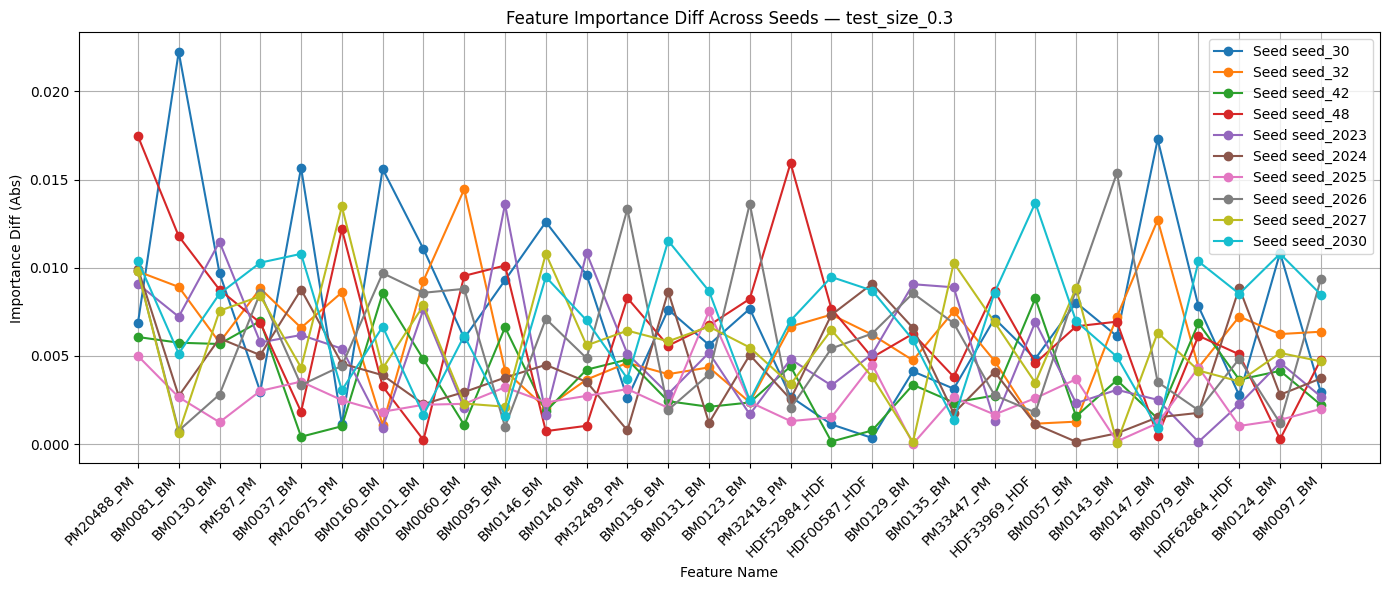

In [19]:
import matplotlib.pyplot as plt

def plot_feature_importance_diff_lines(results_dict, test_size='test_size_0.3', top_k=30):
    seed_dict = results_dict[test_size]

    # 获取所有种子的 feature importance diff，并汇总到字典里
    feature_names = set()
    seed_importance = {}

    for seed, content in seed_dict.items():
        fi_diff = content['feature_importance_diff']
        seed_importance[seed] = {f['name']: f['importance_diff_abs'] for f in fi_diff}
        feature_names.update(seed_importance[seed].keys())

    # 统一的 feature 名单
    feature_names = sorted(feature_names)
    
    # 若设置了 top_k，则只保留重要性平均最高的 top_k 特征
    if top_k:
        # 计算每个特征 across seeds 的平均 importance
        mean_importance = {}
        for feat in feature_names:
            vals = [seed_importance[seed].get(feat, 0) for seed in seed_importance]
            mean_importance[feat] = np.mean(vals)
        feature_names = sorted(mean_importance, key=mean_importance.get, reverse=True)[:top_k]

    x_labels = feature_names
    x_indices = range(len(x_labels))

    # 开始绘图
    plt.figure(figsize=(14, 6))
    for seed, feat_dict in seed_importance.items():
        y_values = [feat_dict.get(name, 0) for name in x_labels]
        plt.plot(x_indices, y_values, label=f'Seed {seed}', marker='o')

    plt.xticks(ticks=x_indices, labels=x_labels, rotation=45, ha='right')
    plt.xlabel("Feature Name")
    plt.ylabel("Importance Diff (Abs)")
    plt.title(f"Feature Importance Diff Across Seeds — {test_size}")
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()
plot_feature_importance_diff_lines(results_dict, test_size='test_size_0.3')


In [25]:
import pandas as pd
import numpy as np

def get_feature_importance_df(results_dict, test_size='test_size_0.3', top_k=30):
    seed_dict = results_dict[test_size]

    # 收集每个 seed 的 importance
    seed_importance = {}
    feature_names = set()

    for seed, content in seed_dict.items():
        fi_diff = content['feature_importance_diff']
        seed_importance[seed] = {f['name']: f['importance_diff_abs'] for f in fi_diff}
        feature_names.update(seed_importance[seed].keys())

    feature_names = sorted(feature_names)

    # 计算所有特征的平均 importance
    mean_importance = {}
    for feat in feature_names:
        vals = [seed_importance[seed].get(feat, 0) for seed in seed_importance]
        mean_importance[feat] = np.mean(vals)

    # 筛选 top_k 特征
    selected_features = sorted(mean_importance, key=mean_importance.get, reverse=True)[:top_k]

    # 构造 DataFrame：行是特征名，列是 seed
    feature_df = pd.DataFrame(index=selected_features)

    for seed in seed_importance:
        feature_df[f'Seed_{seed}'] = [seed_importance[seed].get(feat, 0) for feat in selected_features]

    # 添加平均值列
    feature_df['mean_importance'] = feature_df.mean(axis=1)

    return feature_df

# ✅ 调用函数获取表格
feature_df = get_feature_importance_df(results_dict, test_size='test_size_0.3', top_k=30)

# ✅ 打印前几行看看
print(feature_df.head())


            Seed_seed_30  Seed_seed_32  Seed_seed_42  Seed_seed_48  \
PM20488_PM      0.006863      0.009791      0.006075      0.017462   
BM0081_BM       0.022235      0.008914      0.005752      0.011789   
BM0130_BM       0.009696      0.005767      0.005679      0.008755   
PM587_PM        0.002978      0.008826      0.006975      0.006877   
BM0037_BM       0.015673      0.006598      0.000422      0.001836   

            Seed_seed_2023  Seed_seed_2024  Seed_seed_2025  Seed_seed_2026  \
PM20488_PM        0.009082        0.009950        0.005000        0.009807   
BM0081_BM         0.007225        0.002730        0.002664        0.000769   
BM0130_BM         0.011468        0.005999        0.001244        0.002813   
PM587_PM          0.005770        0.005049        0.003019        0.008578   
BM0037_BM         0.006186        0.008763        0.003547        0.003347   

            Seed_seed_2027  Seed_seed_2030  mean_importance  
PM20488_PM        0.009817        0.010404      

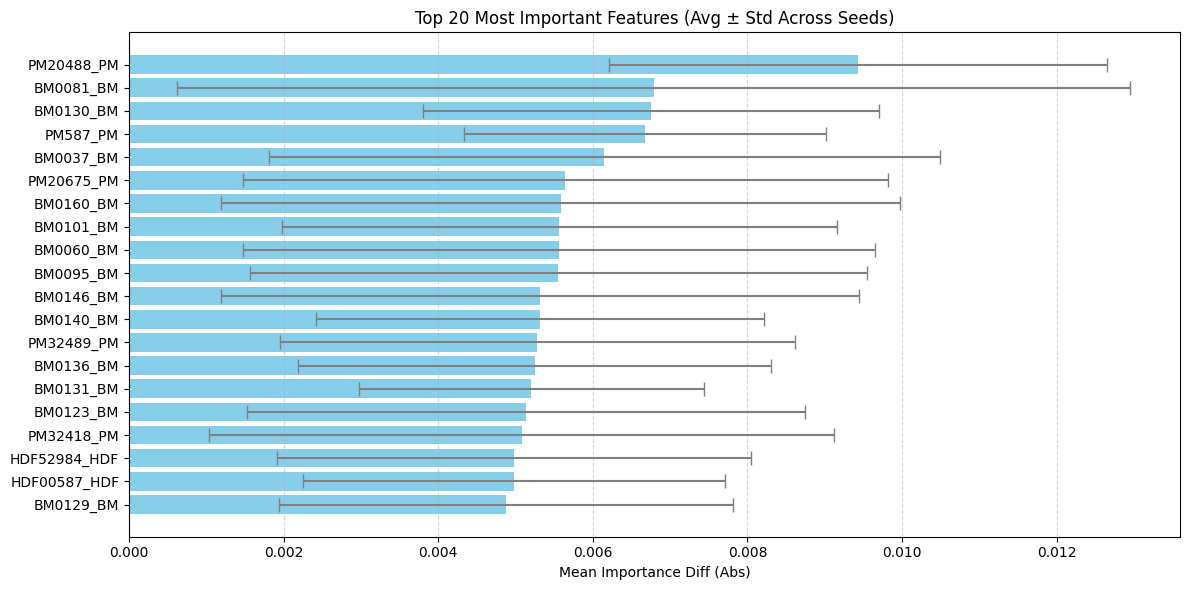

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设你的原始 DataFrame 是 feature_df，行是特征，列是各个 seed
# 1. 计算 mean 和 std
mean_vals = feature_df.mean(axis=1)
std_vals = feature_df.std(axis=1)

# 2. 取前 20 个平均值最大的特征
top20 = mean_vals.nlargest(20)
top20_std = std_vals[top20.index]

# 3. 画柱状图（带误差棒）
plt.figure(figsize=(12, 6))
plt.barh(
    y=top20.index[::-1],  # 反转顺序从上大下小
    width=top20.values[::-1],
    xerr=top20_std.values[::-1],
    color='skyblue',
    ecolor='gray',
    capsize=5
)

plt.xlabel("Mean Importance Diff (Abs)")
plt.title("Top 20 Most Important Features (Avg ± Std Across Seeds)")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


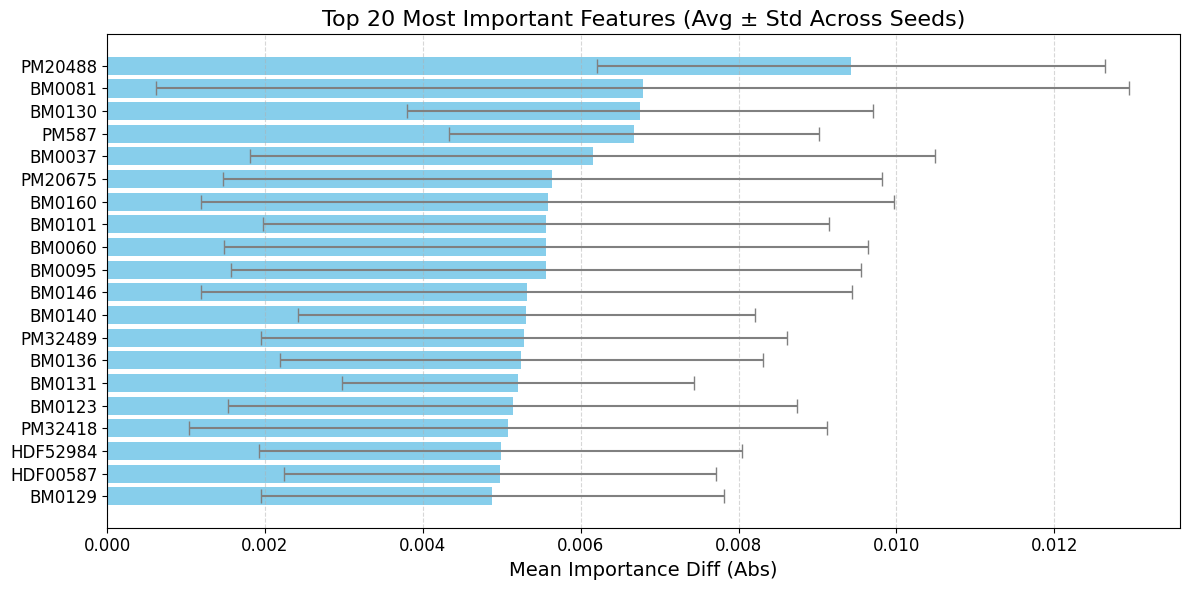

,Feature,Average,StdDev
0,PM20488,0.009425,0.003221
1,BM0081,0.006785,0.006162
2,BM0130,0.006751,0.002954
3,PM587,0.006675,0.002343
4,BM0037,0.006150,0.004342
5,PM20675,0.005641,0.004171
6,BM0160,0.005584,0.004391
7,BM0101,0.005562,0.003589
8,BM0060,0.005562,0.004082
9,BM0095,0.005555,0.003992


In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 计算 mean 和 std (所有特征)
mean_vals = feature_df.mean(axis=1)
std_vals = feature_df.std(axis=1)

# 2. 取前 20 个平均值最大的特征
top20_idx = mean_vals.nlargest(20).index

result_df = pd.DataFrame({
    "Feature": top20_idx,
    "Average": mean_vals[top20_idx].values,
    "StdDev": std_vals[top20_idx].values
})

# 去掉最后一个 _xxx 后缀
result_df["Feature"] = result_df["Feature"].str.replace(r'_[^_]+$', '', regex=True)

# 3. 画柱状图（带误差棒）
plt.figure(figsize=(12, 6))
plt.barh(
    y=result_df["Feature"][::-1],
    width=result_df["Average"][::-1],
    xerr=result_df["StdDev"][::-1],
    color='skyblue',
    ecolor='gray',
    capsize=5
)

plt.xlabel("Mean Importance Diff (Abs)", fontsize=14)
plt.title("Top 20 Most Important Features (Avg ± Std Across Seeds)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 显示表格
display(result_df)


In [33]:
result_df.shape

(30, 3)

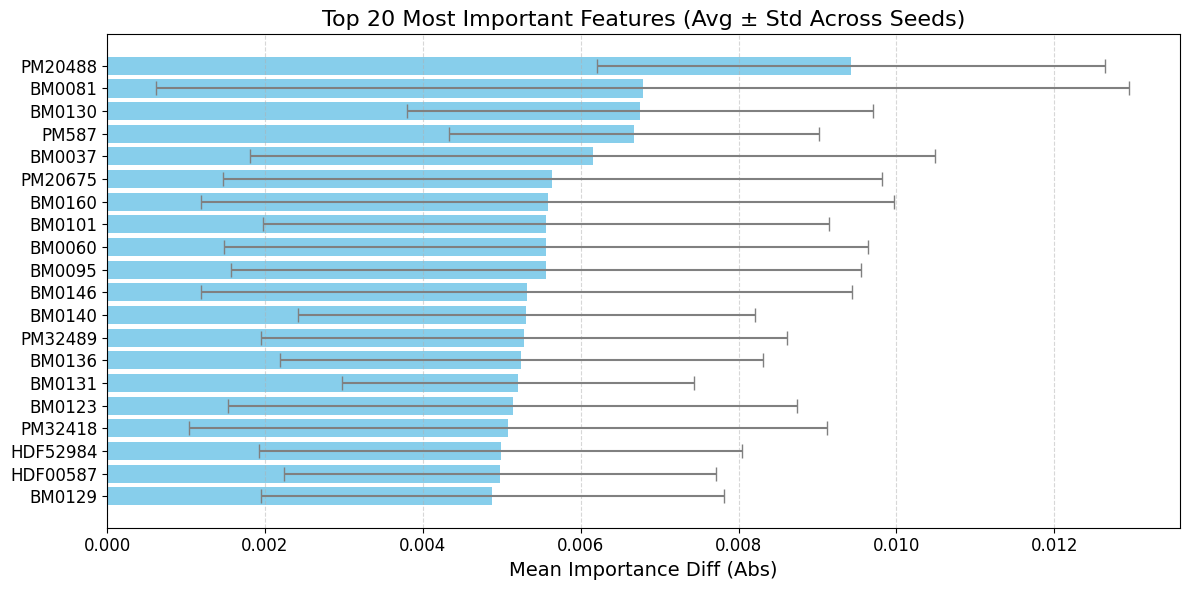

✅ 图片已保存到 C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\Thesis write up\figures\Top20_Features_flexynesis.png


In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# 1. 计算 mean 和 std (所有特征)
mean_vals = feature_df.mean(axis=1)
std_vals = feature_df.std(axis=1)

# 2. 取前 20 个平均值最大的特征
top20_idx = mean_vals.nlargest(20).index

result_df = pd.DataFrame({
    "Feature": top20_idx,
    "Average": mean_vals[top20_idx].values,
    "StdDev": std_vals[top20_idx].values
})

# 去掉最后一个 _xxx 后缀
result_df["Feature"] = result_df["Feature"].str.replace(r'_[^_]+$', '', regex=True)

# 3. 绘制柱状图
plt.figure(figsize=(12, 6))
plt.barh(
    y=result_df["Feature"][::-1],
    width=result_df["Average"][::-1],
    xerr=result_df["StdDev"][::-1],
    color='skyblue',
    ecolor='gray',
    capsize=5
)

plt.xlabel("Mean Importance Diff (Abs)", fontsize=14)
plt.title("Top 20 Most Important Features (Avg ± Std Across Seeds)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()

# 4. 保存图片
save_dir = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\Thesis write up\figures"
save_path = os.path.join(save_dir, "Top20_Features_flexynesis.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ 图片已保存到 {save_path}")


In [45]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns

import copy
import random
import math
import numpy as np
import pandas as pd
from sklearn.utils import check_array
from numpy import linalg as la
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from datetime import datetime

In [47]:
# data import LCMS, HDF

# 1. 指定存放原始与新文件的文件夹
load_path = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\data\preprocessed data"

# 3. after sample alignment
HDF = pd.read_csv(os.path.join(load_path, "S_HDF.csv"), index_col=0)
LD  = pd.read_csv(os.path.join(load_path, "S_LD.csv"),  index_col=0)
PM  = pd.read_csv(os.path.join(load_path, "S_PM.csv"),  index_col=0)
BM  = pd.read_csv(os.path.join(load_path, "S_BM.csv"),  index_col=0)

# metadata import
# female=1, male=0
# diabetic=1, nondiabetic=0
metadata = pd.read_excel(r"C:\Users\laura\OneDrive - Imperial College London\project 2\sample data.xlsx")

metadata['SampleId'] = metadata['SampleId'].astype(int)
HDF.index = HDF.index.astype(int)

merged_df = HDF.merge(
    metadata[['SampleId', 'SEX', 'DIAB', 'AGE', 'BMI']],
    left_index=True,
    right_on='SampleId'
)

merged_df['SEX_num'] = merged_df['SEX'].str.strip().str.lower().map({'female': 1, 'male': 0})
merged_df['DIAB_num'] = merged_df['DIAB'].str.strip().str.lower().map({'diabetic': 1, 'non-diabetic': 0})
print("Unmatched SEX values:", merged_df['SEX_num'].isna().sum())
print("Unmatched DIAB values:", merged_df['DIAB_num'].isna().sum())

y_sex = merged_df['SEX_num']# female=1, male=0
y_dm = merged_df['DIAB_num']# diabetic=1, nondiabetic=0
y_age = merged_df['AGE']
y_bmi=merged_df['BMI']
Y_multi = merged_df[['SEX_num', 'DIAB_num', 'AGE', 'BMI']]



Unmatched SEX values: 0
Unmatched DIAB values: 0


In [49]:
# New threshold apply
p_vals = pd.read_csv(r"C:\Users\laura\OneDrive - Imperial College London\project 2\data in middle steps\permutation test\HDF_3_permutation.csv", header=None).values
# x = pd.concat([hpos, lpos, lneg], axis=1)
x=HDF
pvals_adjusted = np.minimum(p_vals * ( len(p_vals) /65), 1.0)
mask = np.where(pvals_adjusted < 0.05)
HDF_3_selected = x.iloc[:, mask[0]]
print(HDF_3_selected.shape)



p_vals = pd.read_csv(r"C:\Users\laura\OneDrive - Imperial College London\project 2\data in middle steps\permutation test\LD_6_permutation.csv", header=None).values
# x = pd.concat([hpos, lpos, lneg], axis=1)
x=LD
pvals_adjusted = np.minimum(p_vals * ( len(p_vals) /65), 1.0)
mask = np.where(pvals_adjusted < 0.05)
LD_6_selected = x.iloc[:, mask[0]]
print(LD_6_selected.shape)

p_vals = pd.read_csv(r"C:\Users\laura\OneDrive - Imperial College London\project 2\data in middle steps\permutation test\BM_3_permutation.csv", header=None).values
# x = pd.concat([hpos, lpos, lneg], axis=1)
x=BM
pvals_adjusted = np.minimum(p_vals * ( len(p_vals) /65), 1.0)
mask = np.where(pvals_adjusted < 0.05)
BM_3_selected = x.iloc[:, mask[0]]
print(BM_3_selected.shape)

p_vals = pd.read_csv(r"C:\Users\laura\OneDrive - Imperial College London\project 2\data in middle steps\permutation test\PM_4_permutation.csv", header=None).values
# x = pd.concat([hpos, lpos, lneg], axis=1)
x=PM
pvals_adjusted = np.minimum(p_vals * ( len(p_vals) /65), 1.0)
mask = np.where(pvals_adjusted < 0.05)
PM_4_selected = x.iloc[:, mask[0]]
print(PM_4_selected.shape)

p_vals = pd.read_csv(r"C:\Users\laura\OneDrive - Imperial College London\project 2\data in middle steps\permutation test\HDF_BM_5_permutation.csv", header=None).values
# x = pd.concat([hpos, lpos, lneg], axis=1)
x= pd.concat([HDF, BM], axis=1)
pvals_adjusted = np.minimum(p_vals * ( len(p_vals) /65), 1.0)
mask = np.where(pvals_adjusted < 0.05)
HDF_BM_5_selected = x.iloc[:, mask[0]]
print(HDF_BM_5_selected.shape)

#重新收集
p_vals = pd.read_csv(r"C:\Users\laura\OneDrive - Imperial College London\project 2\data in middle steps\permutation test\PM_BM_5_permutation.csv", header=None).values
# x = pd.concat([hpos, lpos, lneg], axis=1)
x= pd.concat([PM, BM], axis=1)
pvals_adjusted = np.minimum(p_vals * ( len(p_vals) /65), 1.0)
mask = np.where(pvals_adjusted < 0.05)
PM_BM_5_selected = x.iloc[:, mask[0]]
print(PM_BM_5_selected.shape)

p_vals = pd.read_csv(r"C:\Users\laura\OneDrive - Imperial College London\project 2\data in middle steps\permutation test\LD_PM_BM_5_permutation.csv", header=None).values
# x = pd.concat([hpos, lpos, lneg], axis=1)
x= pd.concat([LD, PM, BM], axis=1)
pvals_adjusted = np.minimum(p_vals * ( len(p_vals) /65), 1.0)
mask = np.where(pvals_adjusted < 0.05)
LD_PM_BM_5_selected = x.iloc[:, mask[0]]
print(LD_PM_BM_5_selected.shape)

p_vals = pd.read_csv(r"C:\Users\laura\OneDrive - Imperial College London\project 2\data in middle steps\permutation test\HDF_PM_BM_5_permutation.csv", header=None).values
# x = pd.concat([hpos, lpos, lneg], axis=1)
x= pd.concat([HDF, PM, BM], axis=1)
pvals_adjusted = np.minimum(p_vals * ( len(p_vals) /65), 1.0)
mask = np.where(pvals_adjusted < 0.05)
HDF_PM_BM_5_selected = x.iloc[:, mask[0]]
print(HDF_PM_BM_5_selected.shape)

p_vals = pd.read_csv(r"C:\Users\laura\OneDrive - Imperial College London\project 2\data in middle steps\permutation test\HDF_LD_PM_BM_5_permutation.csv", header=None).values
# x = pd.concat([hpos, lpos, lneg], axis=1)
x= pd.concat([HDF, LD, PM, BM], axis=1)
pvals_adjusted = np.minimum(p_vals * ( len(p_vals) /65), 1.0)
mask = np.where(pvals_adjusted < 0.05)
HDF_LD_PM_BM_5_selected = x.iloc[:, mask[0]]
print(HDF_LD_PM_BM_5_selected.shape)

(282, 15)
(282, 5)
(282, 2)
(282, 8)
(282, 20)
(282, 8)
(282, 16)
(282, 24)
(282, 20)


In [53]:
# Name checking file
import pandas as pd

base_path = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\data\raw data file"
# 文件名和变量名对应字典
files = {
    "BM_feature": "BM_feature.xlsx",
    "HDF_feature": "HDF_feature.xlsx",
    "LD_feature": "LD_feature.xlsx",
    "PM_feature": "PM_feature.xlsx"
}
dfs = {}
for name, file in files.items():
    file_path = f"{base_path}\\{file}"
    dfs[name] = pd.read_excel(file_path, header=0, index_col=0)
for name, df in dfs.items():
    print(f"Checking {name} dataset:")
    
    # 检查 'FeatureId' 和 'name' 列是否存在
    if 'FeatureId' in df.columns and 'name' in df.columns:
        # 提取 'FeatureId' 和 'name' 列
        extracted_data = df[['FeatureId', 'name']]
        print(f"Extracted data from {name}:\n", extracted_data.head())  # 打印前几行提取的数据
    else:
        print(f"{name} does not contain 'FeatureId' or 'name' columns.")

    print('-' * 50)

Checking BM_feature dataset:
Extracted data from BM_feature:
        FeatureId          name
BM0001    BM0001     C0 [p150]
BM0002    BM0002    C10 [p150]
BM0003    BM0003  C10.1 [p150]
BM0004    BM0004  C10.2 [p150]
BM0005    BM0005    C12 [p150]
--------------------------------------------------
Checking HDF_feature dataset:
Extracted data from HDF_feature:
          FeatureId                                               name
HDF38768  HDF38768  (14 or 15)-methylpalmitate (a17:0 or i17:0) [HD4]
HDF38296  HDF38296   (16 or 17)-methylstearate (a19:0 or i19:0) [HD4]
HDF62533  HDF62533          (2,4 or 2,5)-dimethylphenol sulfate [HD4]
HDF57814  HDF57814               (N(1) + N(8))-acetylspermidine [HD4]
HDF48762  HDF48762               1,2,3-benzenetriol sulfate (2) [HD4]
--------------------------------------------------
Checking LD_feature dataset:
Extracted data from LD_feature:
          FeatureId           name
CE(12:0)  CE(12:0)  CE(12:0) [LD]
CE(14:0)  CE(14:0)  CE(14:0) [LD]
CE

In [55]:
p_vals

array([[9.78886e-01],
       [8.86677e-01],
       [9.38725e-01],
       ...,
       [5.37908e-01],
       [8.34708e-01],
       [6.68000e-04]])

In [57]:
# Name and feature list 

feature_name = []

for name, df in dfs.items():
    if 'FeatureId' in df.columns and 'name' in df.columns:
        extracted_data = df[['FeatureId', 'name']]
        extracted_data['dataset'] = name
        feature_name.append(extracted_data)

# 合并所有数据集中的数据
feature_name = pd.concat(feature_name, ignore_index=True)

# 打印结果
print(feature_name.head())
print(feature_name.shape)


  FeatureId          name     dataset
0    BM0001     C0 [p150]  BM_feature
1    BM0002    C10 [p150]  BM_feature
2    BM0003  C10.1 [p150]  BM_feature
3    BM0004  C10.2 [p150]  BM_feature
4    BM0005    C12 [p150]  BM_feature
(3356, 3)


In [61]:
pvals_adjusted

array([[1.        ],
       [1.        ],
       [1.        ],
       ...,
       [1.        ],
       [1.        ],
       [0.02790185]])

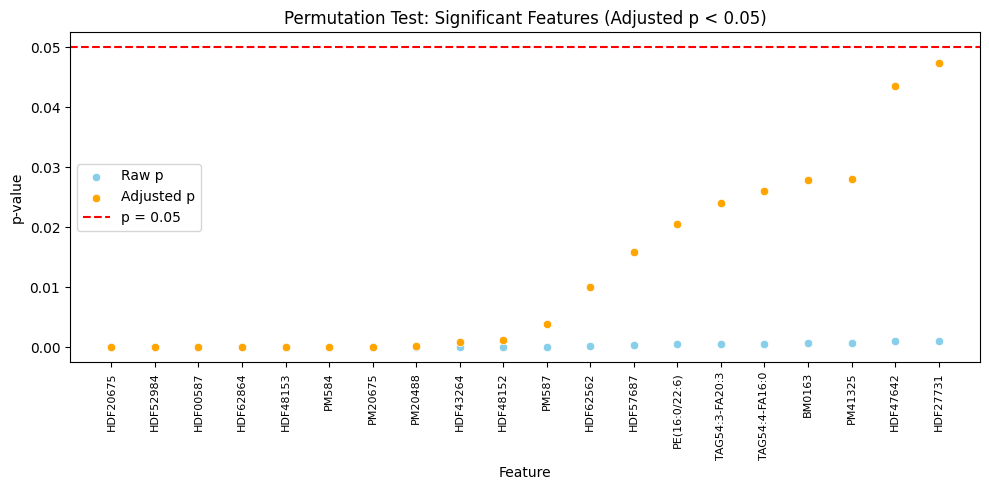

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------
# 读取数据
# ------------------------
p_vals = pd.read_csv(r"C:\Users\laura\OneDrive - Imperial College London\project 2\data in middle steps\permutation test\HDF_LD_PM_BM_5_permutation.csv", header=None).values.flatten()
x = pd.concat([HDF, LD, PM, BM], axis=1)

# Bonferroni 校正
pvals_adjusted = np.minimum(p_vals * (len(p_vals) / 65), 1.0).flatten()

# ------------------------
# 找出显著特征
# ------------------------
mask = np.where(pvals_adjusted < 0.05)
selected_idx = mask[0]
selected_features = x.columns[selected_idx]
selected_raw_pvals = p_vals[selected_idx]
selected_adj_pvals = pvals_adjusted[selected_idx]

# 构建绘图 DataFrame
df_plot = pd.DataFrame({
    'Feature': selected_features,
    'Raw p-value': selected_raw_pvals,
    'Adjusted p-value': selected_adj_pvals
})

# 按调整后p值排序
df_plot = df_plot.sort_values('Adjusted p-value').reset_index(drop=True)

# ------------------------
# 画图
# ------------------------
plt.figure(figsize=(max(8, 0.5 * len(df_plot)), 5))  # 根据特征数量自适应宽度

# 原始 p 值
sns.scatterplot(x='Feature', y='Raw p-value', data=df_plot, color='skyblue', label='Raw p')
# 调整后 p 值
sns.scatterplot(x='Feature', y='Adjusted p-value', data=df_plot, color='orange', label='Adjusted p')

# 显著性参考线
plt.axhline(0.05, color='red', linestyle='--', label='p = 0.05')

# 美化 x 轴
plt.xticks(rotation=90, fontsize=8)
plt.xlabel('Feature')
plt.ylabel('p-value')
plt.title('Permutation Test: Significant Features (Adjusted p < 0.05)')
plt.legend()
plt.tight_layout()
plt.show()


<Figure size 1600x1000 with 0 Axes>

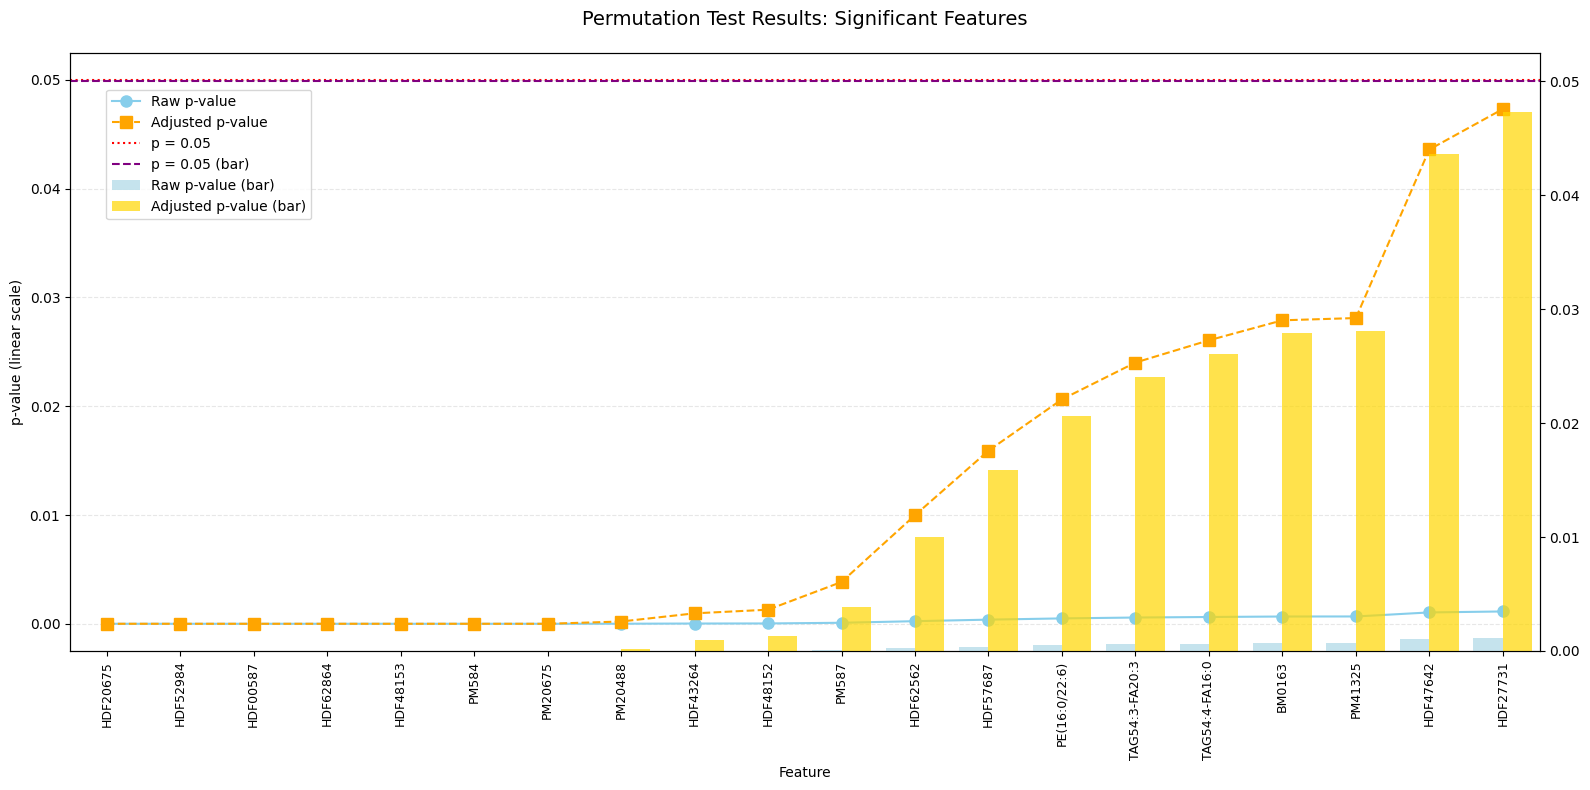

Significant Features Summary:
           Feature  Raw p-value  Adjusted p-value
0         HDF20675     0.000000          0.000000
1         HDF52984     0.000000          0.000000
2         HDF00587     0.000000          0.000000
3         HDF62864     0.000000          0.000000
4         HDF48153     0.000000          0.000000
5            PM584     0.000000          0.000000
6          PM20675     0.000000          0.000000
7          PM20488     0.000005          0.000209
8         HDF43264     0.000023          0.000961
9         HDF48152     0.000031          0.001295
10           PM587     0.000092          0.003843
11        HDF62562     0.000239          0.009983
12        HDF57687     0.000381          0.015914
13   PE(16:0/22:6)     0.000494          0.020634
14  TAG54:3-FA20:3     0.000575          0.024017
15  TAG54:4-FA16:0     0.000624          0.026064
16          BM0163     0.000668          0.027902
17         PM41325     0.000673          0.028111
18        HDF47642  

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# ------------------------
# 读取数据
# ------------------------
p_vals = pd.read_csv(
    r"C:\Users\laura\OneDrive - Imperial College London\project 2\data in middle steps\permutation test\HDF_LD_PM_BM_5_permutation.csv",
    header=None).values.flatten()
x = pd.concat([HDF, LD, PM, BM], axis=1)

# Bonferroni 校正
pvals_adjusted = np.minimum(p_vals * (len(p_vals) / 65), 1.0).flatten()

# 找出显著特征
mask = np.where(pvals_adjusted < 0.05)
selected_idx = mask[0]
selected_features = x.columns[selected_idx].tolist()
selected_raw_pvals = p_vals[selected_idx]
selected_adj_pvals = pvals_adjusted[selected_idx]

# 构建绘图 DataFrame
df_plot = pd.DataFrame({
    'Feature': selected_features,
    'Raw p-value': selected_raw_pvals,
    'Adjusted p-value': selected_adj_pvals
})

# 按调整后p值排序
df_plot = df_plot.sort_values('Adjusted p-value', ascending=True).reset_index(drop=True)

# ------------------------
# 可视化
# ------------------------
plt.figure(figsize=(max(12, 0.8 * len(df_plot)), 10))

fig, ax1 = plt.subplots(figsize=(max(12, 0.8 * len(df_plot)), 8))

# 左 y 轴：p 值（线性）
ax1.set_xlabel('Feature')
ax1.set_ylabel('p-value (linear scale)')

# 画折线
ax1.plot(df_plot['Feature'], df_plot['Raw p-value'], 'o-', color='skyblue', markersize=8, label='Raw p-value')
ax1.plot(df_plot['Feature'], df_plot['Adjusted p-value'], 's--', color='orange', markersize=8, label='Adjusted p-value')

ax1.axhline(0.05, color='red', linestyle=':', label='p = 0.05')

# 右 y 轴：柱状图
ax2 = ax1.twinx()
ax2.set_ylabel('')  # 去掉绿色标签文字

bar_width = 0.4
indices = np.arange(len(df_plot))

ax2.bar(indices - 0.2, df_plot['Raw p-value'], width=bar_width, color='lightblue', alpha=0.7, label='Raw p-value (bar)')
ax2.bar(indices + 0.2, df_plot['Adjusted p-value'], width=bar_width, color='gold', alpha=0.7, label='Adjusted p-value (bar)')

ax2.axhline(0.05, color='purple', linestyle='--', label='p = 0.05 (bar)')

ax1.set_xticks(indices)
ax1.set_xticklabels(df_plot['Feature'], rotation=90, fontsize=9)
ax1.set_xlim(-0.5, len(df_plot) - 0.5)

ax1.grid(True, which='both', linestyle='--', alpha=0.3, axis='y')
ax2.grid(False)

# 合并图例，放左中上（图内偏左上）
lines, labels = ax1.get_legend_handles_labels()
bars, bar_labels = ax2.get_legend_handles_labels()
ax1.legend(lines + bars, labels + bar_labels, loc='upper left', bbox_to_anchor=(0.02, 0.95))

plt.title('Permutation Test Results: Significant Features', fontsize=14, pad=20)

plt.tight_layout()

# 自动创建文件夹，保存图片
save_dir = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\Thesis write up\figures"
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, 'permutation_test_significant_features_MAMSI.png')

plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print("Significant Features Summary:")
print(df_plot)


In [67]:
df_plot

,Feature,Raw p-value,Adjusted p-value
0,HDF20675,0.000000,0.000000
1,HDF52984,0.000000,0.000000
2,HDF00587,0.000000,0.000000
3,HDF62864,0.000000,0.000000
4,HDF48153,0.000000,0.000000
5,PM584,0.000000,0.000000
6,PM20675,0.000000,0.000000
7,PM20488,0.000005,0.000209
8,HDF43264,0.000023,0.000961
9,HDF48152,0.000031,0.001295


In [69]:
result_df

,Feature,Average,StdDev
0,PM20488,0.009425,0.003221
1,BM0081,0.006785,0.006162
2,BM0130,0.006751,0.002954
3,PM587,0.006675,0.002343
4,BM0037,0.006150,0.004342
5,PM20675,0.005641,0.004171
6,BM0160,0.005584,0.004391
7,BM0101,0.005562,0.003589
8,BM0060,0.005562,0.004082
9,BM0095,0.005555,0.003992


<Figure size 1000x600 with 0 Axes>

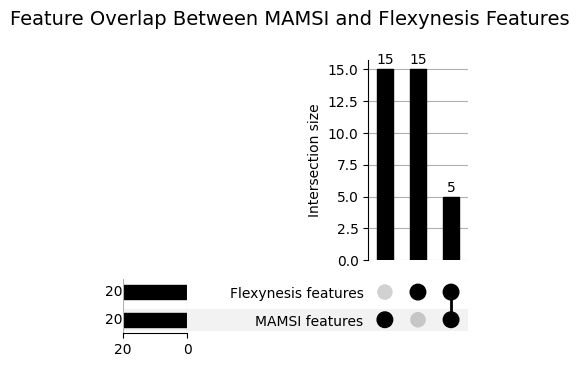

✅ 图片已保存到: C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\Thesis write up\figures\FeatureOverlap_Flexynesis_MAMSI.png


In [101]:
import pandas as pd
from upsetplot import UpSet, from_contents
import matplotlib.pyplot as plt

# 提取两个特征集合
set1 = set(df_plot['Feature'])
set2 = set(result_df['Feature'])

# 构造字典表示两个集合
contents = {
    'MAMSI features': set1,
    'Flexynesis features': set2,
}

# 生成upsetplot需要的数据格式
data = from_contents(contents)

# 画图
plt.figure(figsize=(10,6))
upset = UpSet(data, show_counts='%d', sort_by='cardinality')
upset.plot()

plt.suptitle('Feature Overlap Between MAMSI and Flexynesis Features', y=1.02, fontsize=14)

# 保存图片
save_path = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\Thesis write up\figures\FeatureOverlap_Flexynesis_MAMSI.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()

print(f"✅ 图片已保存到: {save_path}")


In [77]:
# 提取两个特征集合
set1 = set(df_plot['Feature'])
set2 = set(result_df['Feature'])

# 计算交集（重合特征）
overlap = set1.intersection(set2)

print(f"两个列表共有 {len(overlap)} 个重合特征：")
print(sorted(overlap))


两个列表共有 5 个重合特征：
['HDF00587', 'HDF52984', 'PM20488', 'PM20675', 'PM587']


In [79]:
import pandas as pd

# 假设 result_df 已经存在，且包含 Feature, Average, StdDev 三列

# 提取字母前缀，假设都是字母开头，数字结尾
result_df['Source'] = result_df['Feature'].str.extract(r'^([A-Za-z]+)')

# 统计每个来源的数量
source_counts = result_df['Source'].value_counts()

# 计算比例
source_ratio = source_counts / source_counts.sum()

# 合并成表方便查看
source_summary = pd.DataFrame({
    'Count': source_counts,
    'Ratio': source_ratio
})

print(source_summary)


        Count  Ratio
Source              
BM         13   0.65
PM          5   0.25
HDF         2   0.10


In [87]:
import pandas as pd
from upsetplot import from_contents

# 定义来源判定函数
def assign_source_prefix2(feature):
    prefix = feature[:2]
    if prefix in ['HD', 'BM', 'PM', 'LD']:
        return prefix
    else:
        return 'LD'

# 两个集合
set1 = set(df_plot['Feature'])
set2 = set(result_df['Feature'])

contents = {
    'df_plot': set1,
    'result_df': set2
}
data = from_contents(contents)

# 存储结果
intersection_labels = []
source_counts_list = []

seen = set()  # 避免重复统计

for ix in data.index:
    included_sets = tuple(name for name, included in zip(data.index.names, ix) if included)
    if not included_sets or included_sets in seen:
        continue
    seen.add(included_sets)

    feats = set.intersection(*[contents[name] for name in included_sets])
    sources = [assign_source_prefix2(f) for f in feats]
    counts = pd.Series(sources).value_counts()

    label = '&'.join(included_sets)
    intersection_labels.append(label)
    source_counts_list.append(counts)

# 合并结果
source_df = pd.DataFrame(source_counts_list, index=intersection_labels).fillna(0).astype(int)
source_df['Total'] = source_df.sum(axis=1)  # 加上总数列

print("每个UpSet Plot柱子的来源分布：")
print(source_df)


每个UpSet Plot柱子的来源分布：
                   HD  PM  LD  BM  Total
df_plot            11   5   3   1     20
df_plot&result_df   2   3   0   0      5
result_df           2   5   0  13     20


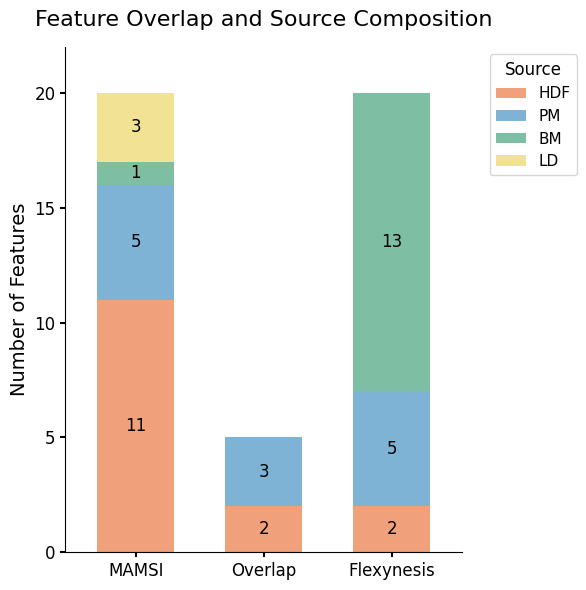

✅ 图像（保留x轴和y轴）已保存至：C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\Thesis write up\figures\feature_overlap_source_composition_xy_border.png


In [139]:
import matplotlib.pyplot as plt
import numpy as np
import os

colors = {
    'HDF': '#F0A07B',
    'PM':  '#7FB3D5',
    'BM':  '#7EBFA3',
    'LD':  '#F2E394'
}

plot_df = source_df.rename(columns={'HD': 'HDF'})[['HDF','PM','BM','LD']]
plot_df.index = ['MAMSI', 'Overlap', 'Flexynesis']

fig, ax = plt.subplots(figsize=(6,6))

plot_df.plot(kind='bar', stacked=True, color=[colors[c] for c in plot_df.columns], ax=ax, width=0.6)

for c in ax.containers:
    ax.bar_label(c, labels=[f'{v:.0f}' if v > 0 else '' for v in c.datavalues],
                 label_type='center', color='black', fontsize=12)

ax.set_ylabel('Number of Features', fontsize=14)
ax.set_xlabel('')
ax.set_title('Feature Overlap and Source Composition', fontsize=16, pad=15)
ax.tick_params(axis='x', labelsize=12, labelrotation=0, width=1.5)
ax.tick_params(axis='y', labelsize=12, width=1.5)

y_max = plot_df.sum(axis=1).max()
ax.set_yticks(np.arange(0, y_max+6, 5))
ax.set_ylim(0, y_max + 2)

# 只保留x轴和y轴边框
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.legend(title="Source", title_fontsize=12, fontsize=11, 
           bbox_to_anchor=(1.05,1), loc='upper left')

plt.tight_layout()

save_dir = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\Thesis write up\figures"
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "feature_overlap_source_composition_xy_border.png")

plt.savefig(save_path, dpi=300)
plt.show()

print(f"✅ 图像（保留x轴和y轴）已保存至：{save_path}")
